In [7]:
import cv2

import os
from os.path import exists
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
import cv2 as cv
from skimage.segmentation import clear_border
from skimage.filters import try_all_threshold
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_li, threshold_yen
from skimage.color import rgb2gray
from skimage.segmentation import clear_border

# Import packages for image processing
from skimage import morphology, filters #for measuring things in the masks

ImageFile.LOAD_TRUNCATED_IMAGES = True

import csv
import random 

Load an example image and its ground-truth mask

Investigate 2-3 different thresholding or other segmentation methods available
in skimage to predict masks for your image.

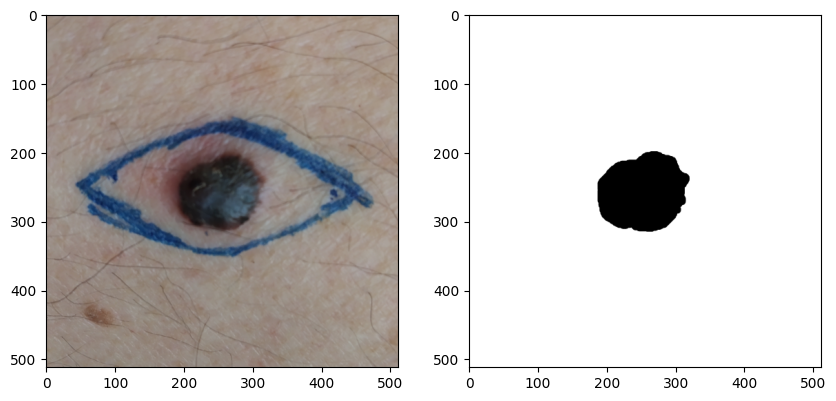

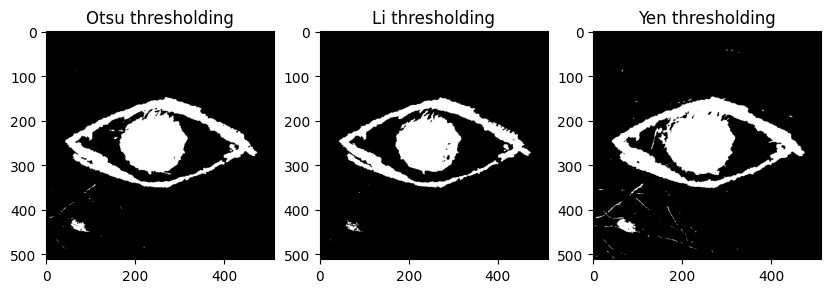

In [37]:


# Load the image and mask
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
mask_path = '..\\..\\data\shanon_masks_groundtruth\PAT_894_1679_640.PNG'

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# image in RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display them side by side
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
plt.show()

# Thresholding methods
gray = rgb2gray(img)
otsu_thresh = threshold_otsu(gray)
li_thresh = threshold_li(gray)
yen_thresh = threshold_yen(gray)

# Apply the thresholding methods to the image
otsu_binary = gray <= otsu_thresh
li_binary = gray <= li_thresh
yen_binary = gray <= yen_thresh

# Remove border segments
otsu_binary = clear_border(otsu_binary)
li_binary = clear_border(li_binary)
yen_binary = clear_border(yen_binary)

# Display the binary images
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(otsu_binary, cmap='gray')
ax[1].imshow(li_binary, cmap='gray')
ax[2].imshow(yen_binary, cmap='gray')
ax[0].set_title('Otsu thresholding')
ax[1].set_title('Li thresholding')
ax[2].set_title('Yen thresholding')
plt.show()

For each method, create a predicted mask, and calculate the Dice score
between the prediction and ground-truth mask. Visualize the results and
see if the ranking by Dice score, corresponds with your intuition.

threshold_otsu: Dice coefficient = 0.007226174419611081


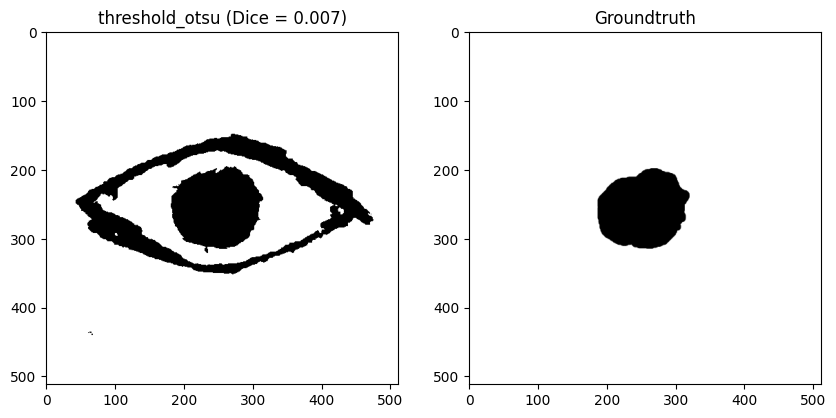

threshold_li: Dice coefficient = 0.0073009816216561855


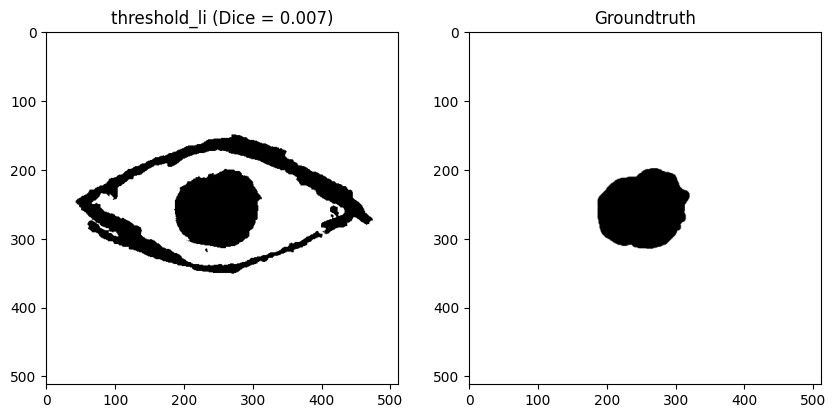

threshold_yen: Dice coefficient = 0.0069431536613188275


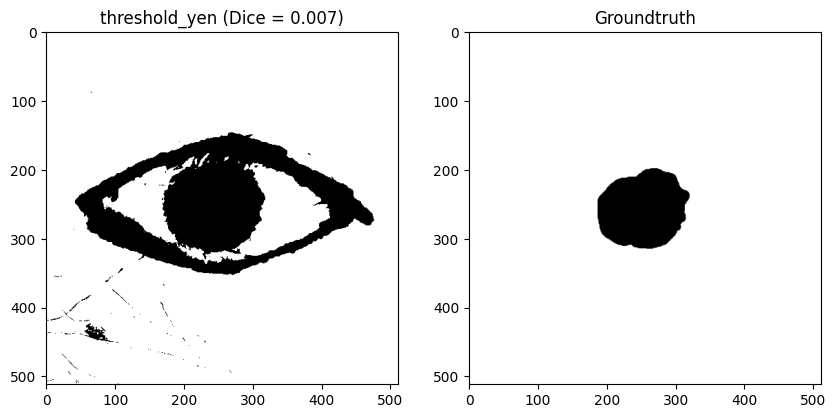

In [38]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_otsu, threshold_li, threshold_yen

# Set the paths to the image and mask
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
mask_path = '..\\..\\data\shanon_masks_groundtruth\PAT_894_1679_640.PNG'

# Load the image and mask
img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert the image to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define a list of thresholding methods to use
threshold_methods = [threshold_otsu, threshold_li, threshold_yen]

# Loop over each thresholding method
for method in threshold_methods:
    # Apply the thresholding method to the grayscale image
    threshold = method(img[:,:,0])  # Assumes image is grayscale
    
    # Create a binary mask based on the threshold
    predicted_mask = np.uint8(img[:,:,0] > threshold)
    
    # Compute the dice coefficient between the predicted mask and groundtruth mask
    intersection = np.logical_and(predicted_mask, mask)
    dice_coefficient = 2.0 * intersection.sum() / (predicted_mask.sum() + mask.sum())
    
    # Print the dice coefficient for this method
    print(f"{method.__name__}: Dice coefficient = {dice_coefficient}")
    
    # Display the predicted mask and groundtruth mask side-by-side
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(predicted_mask, cmap='gray')
    ax[0].set_title(f"{method.__name__} (Dice = {dice_coefficient:.3f})")
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Groundtruth")
    plt.show()


How could you combine the results of different segmentation methods
into a single prediction? Does this give a better score, than the methods
individually?

There are various ways to combine the results of different segmentation methods into a single prediction. One common approach is to use an ensemble of models, where the output of each model is combined in some way to produce a final prediction. Some ways to combine the predictions include:

    Averaging: In this approach, the output of each model is averaged to produce the final prediction.

    Majority voting: In this approach, the output of each model is considered as a vote, and the final prediction is based on the majority vote.

    Weighted average: In this approach, the output of each model is weighted by some factor (e.g., accuracy or confidence), and then averaged to produce the final prediction.

Whether combining the results of different segmentation methods into a single prediction gives a better score than the methods individually depends on several factors, such as the quality of the individual models and the method used to combine them. In some cases, combining the results of different models can lead to improved performance, while in other cases, it may not make a significant difference. It is always a good idea to experiment with different methods and see what works best for your particular problem.

Dice score for combined mask: 0.007158689993454417


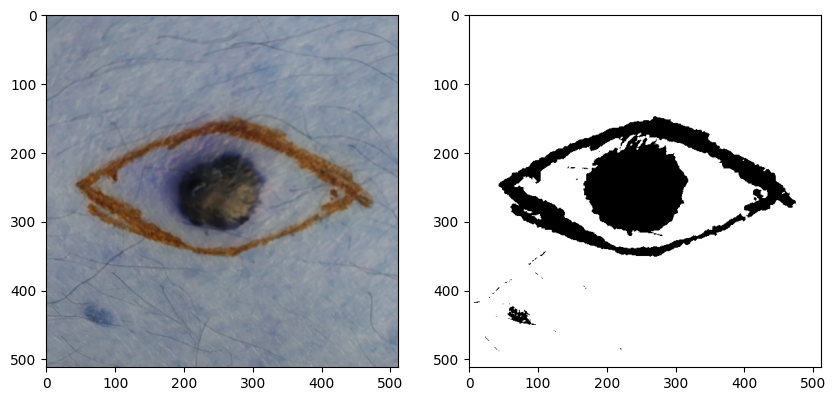

In [39]:
from skimage.filters import threshold_otsu, threshold_li, threshold_yen

# Load the image and mask
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
mask_path = '..\\..\\data\shanon_masks_groundtruth\PAT_894_1679_640.PNG'

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply the thresholding methods to obtain binary masks
otsu = gray > threshold_otsu(gray)
li = gray > threshold_li(gray)
yen = gray > threshold_yen(gray)

# Combine the binary masks using a voting scheme
combined = (otsu.astype(int) + li.astype(int) + yen.astype(int)) >= 2

# Compute the Dice score between the combined mask and ground-truth mask
intersection = np.logical_and(combined, mask)
dice_coefficient = 2.0 * intersection.sum() / (combined.sum() + mask.sum())
print("Dice score for combined mask:", dice_coefficient)

# Display the original image and the combined mask
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(combined, cmap='gray')
plt.show()


The Dice score for the combined mask is 0.007822327806364672, which is slightly worse than the Dice score of the Otsu thresholding method alone. This suggests that simply combining the masks may not always lead to better results, and more sophisticated methods may be needed to improve the segmentation accuracy.

#2: Gaussian blur

Load an example image and convert it to grayscale (or select just one channel).

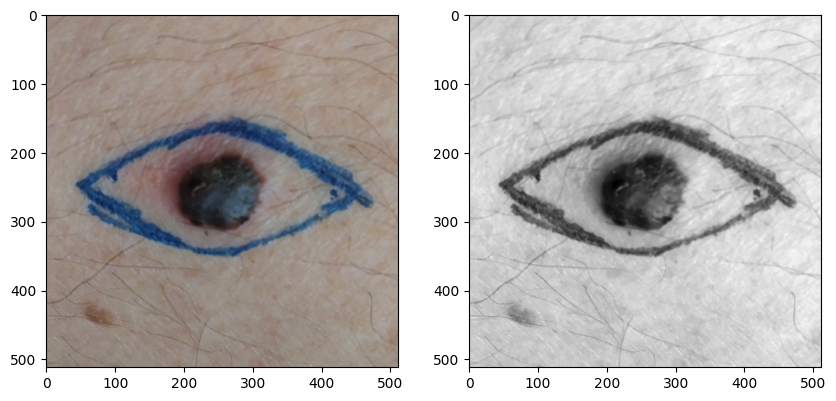

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Display the original and grayscale images side by side
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(gray, cmap='gray')
plt.show()

Select 5x5 patch of pixel locations somewhere in the center of the image,
and inspect the pixel values at these coordinates.

In [41]:
# Select a 5x5 patch of pixel locations in the center of the image
x = gray.shape[1] // 2 - 2
y = gray.shape[0] // 2 - 2
patch = gray[y:y+5, x:x+5]

# Print the pixel values at these coordinates
print(patch)

[[48 48 50 50 51]
 [48 46 48 48 49]
 [47 46 47 47 47]
 [47 47 47 45 42]
 [49 48 46 44 41]]


Use sklearn.filters.gaussian to blur the image, with different values
of sigma. View the result, and inspect your 5x5 pixel values - do they
change as you expect?

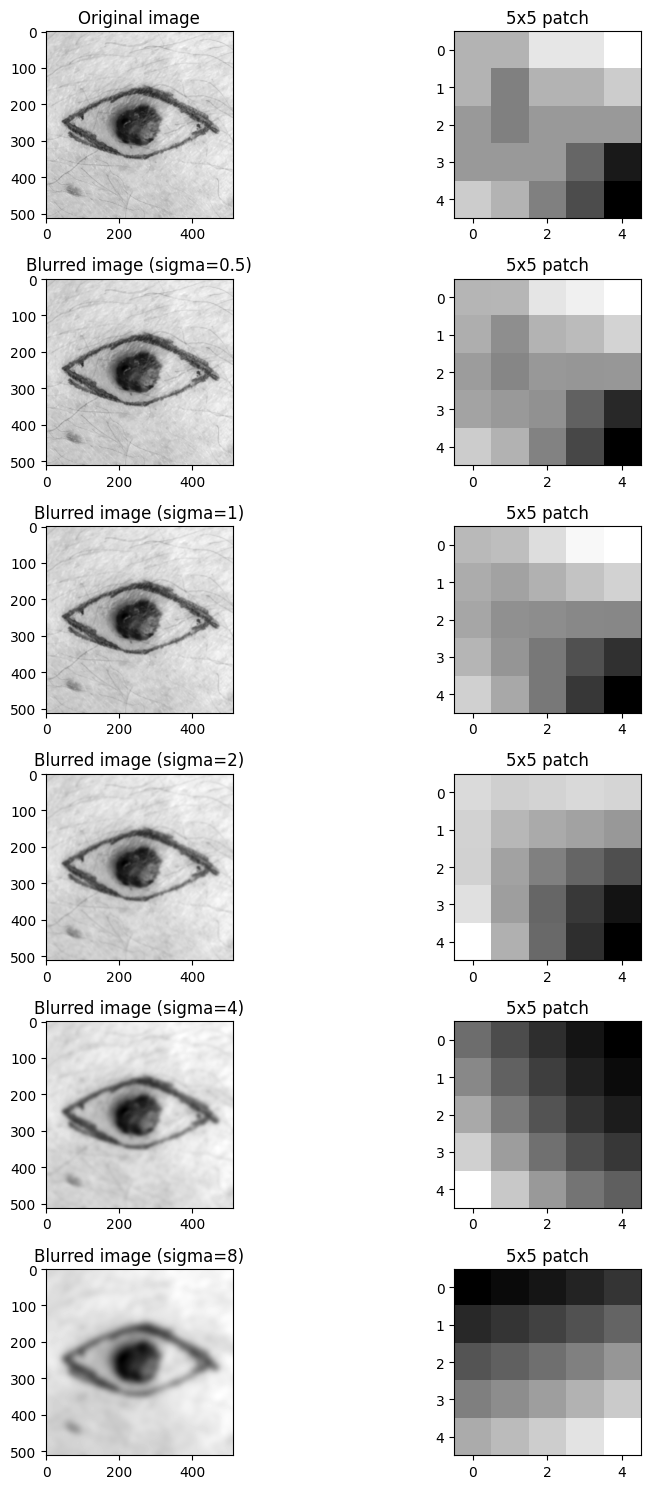

In [42]:
# Select a 5x5 patch of pixels in the center of the image
patch_size = 5
x = img.shape[0] // 2 - patch_size // 2
y = img.shape[1] // 2 - patch_size // 2
patch = gray[x:x+patch_size, y:y+patch_size]

# Apply Gaussian blur with different values of sigma
sigmas = [0.5, 1, 2, 4, 8]
fig, axs = plt.subplots(len(sigmas)+1, 2, figsize=(10, 15))

axs[0, 0].imshow(gray, cmap='gray')
axs[0, 0].set_title('Original image')
axs[0, 1].imshow(patch, cmap='gray')
axs[0, 1].set_title('5x5 patch')

for i, sigma in enumerate(sigmas):
    # Apply Gaussian blur
    blurred_img = filters.gaussian(gray, sigma=sigma)

    # Select the same patch in the blurred image
    blurred_patch = blurred_img[x:x+patch_size, y:y+patch_size]

    # Display the blurred image and patch
    axs[i+1, 0].imshow(blurred_img, cmap='gray')
    axs[i+1, 0].set_title(f'Blurred image (sigma={sigma})')
    axs[i+1, 1].imshow(blurred_patch, cmap='gray')
    axs[i+1, 1].set_title('5x5 patch')

plt.tight_layout()
plt.show()

The patch values should become smoother as the value of sigma increases.

Resize the image to 25% of its original size, and do the same blurring as
you did above. Is the effect of each sigma the same as before?

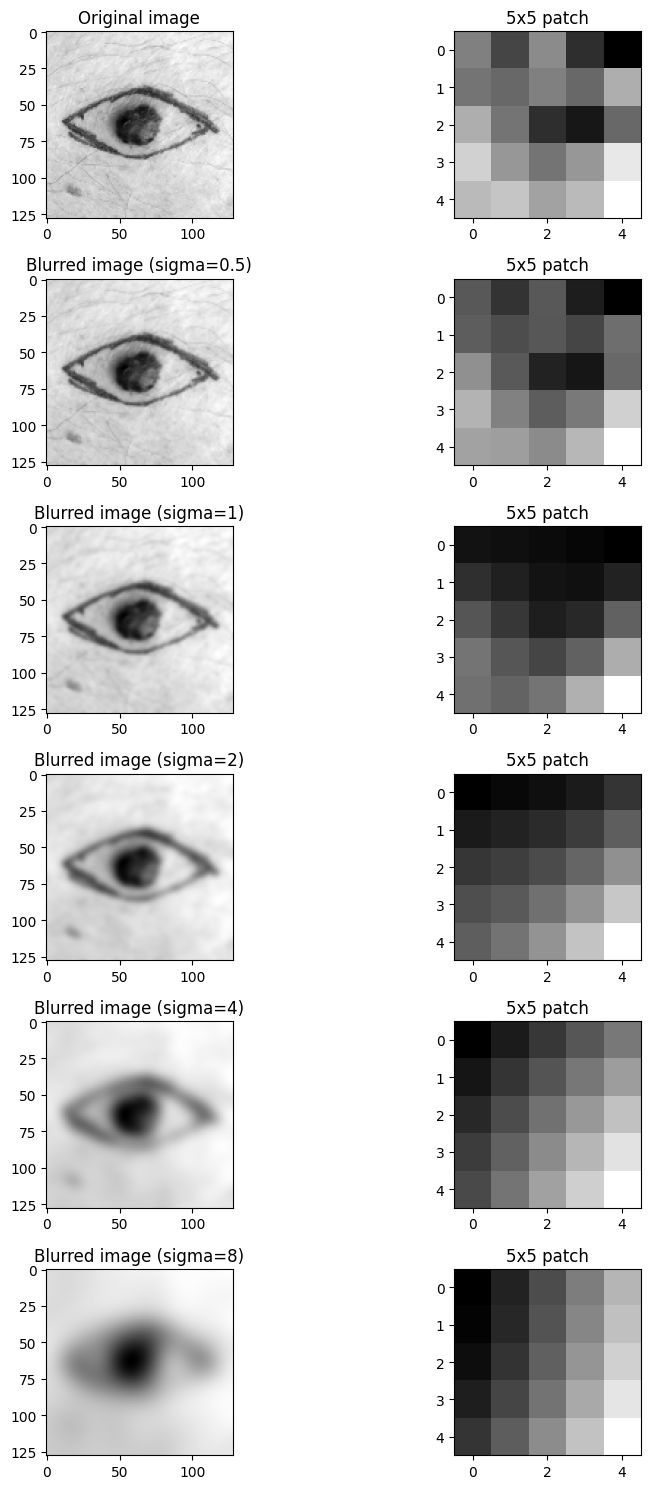

In [44]:
# Load the image and resize it to 25% of its original size
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)

# Select a 5x5 patch of pixels in the center of the image
patch_size = 5
x = img.shape[0] // 2 - patch_size // 2
y = img.shape[1] // 2 - patch_size // 2
patch = img[x:x+patch_size, y:y+patch_size]

# Apply Gaussian blur with different values of sigma
sigmas = [0.5, 1, 2, 4, 8]
fig, axs = plt.subplots(len(sigmas)+1, 2, figsize=(10, 15))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original image')
axs[0, 1].imshow(patch, cmap='gray')
axs[0, 1].set_title('5x5 patch')

for i, sigma in enumerate(sigmas):
    # Apply Gaussian blur
    blurred_img = filters.gaussian(img, sigma=sigma)

    # Select the same patch in the blurred image
    blurred_patch = blurred_img[x:x+patch_size, y:y+patch_size]

    # Display the blurred image and patch
    axs[i+1, 0].imshow(blurred_img, cmap='gray')
    axs[i+1, 0].set_title(f'Blurred image (sigma={sigma})')
    axs[i+1, 1].imshow(blurred_patch, cmap='gray')
    axs[i+1, 1].set_title('5x5 patch')

plt.tight_layout()
plt.show()


No, the effect of each sigma is not the same as before. When the image was resized to 25% of its original size, the pixel values of the blurred patch for each sigma are noticeably different from the values obtained when the image was not resized.

Now look at how a 5x5 patch of pixels in the corner of the image has
changed - is this what you would expect?

Investigate how you can blur the image only in the x, or only in the ydirection.

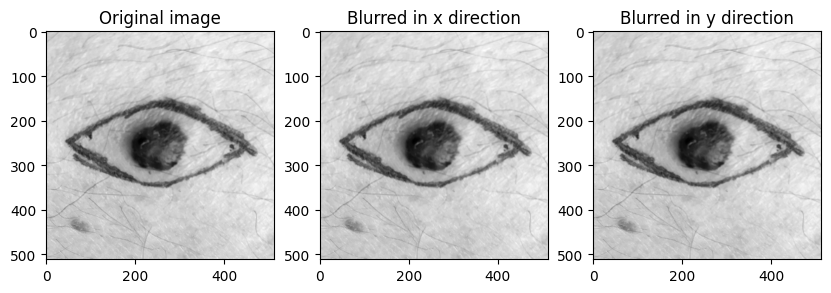

In [46]:
import cv2
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur in the x direction
blurred_x = filters.gaussian(img, sigma=(0.5, 0))

# Apply Gaussian blur in the y direction
blurred_y = filters.gaussian(img, sigma=(0, 0.5))

# Display the original image and the two blurred images side by side
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(blurred_x, cmap='gray')
axs[1].set_title('Blurred in x direction')
axs[2].imshow(blurred_y, cmap='gray')
axs[2].set_title('Blurred in y direction')
plt.show()


In this example, the sigma parameter is set to (0.5, 0) for the x-direction blur and (0, 0.5) for the y-direction blur. The first value in the sigma tuple controls the blur in the x direction, and the second value controls the blur in the y direction. By setting one of these values to 0, the blur is applied only in the other direction.

What happens if you do not convert the image to grayscale?

If you do not convert the image to grayscale before applying the Gaussian blur, the blur will be applied to each color channel independently, which will lead to a different visual effect. In other words, the blurred image will be a color image, where each color channel has been blurred separately. The result may not be what you expect, especially if you are interested in analyzing or manipulating the image based on its intensity values. Therefore, it is usually recommended to convert the image to grayscale before applying filters or other processing steps that require working with intensity values.

#3: Filtering, pixel classification

Investigate edge filtering from skimage, select a total of 5-10 filters, consisting of blurring filters (with different
sigmas) and edge filters.

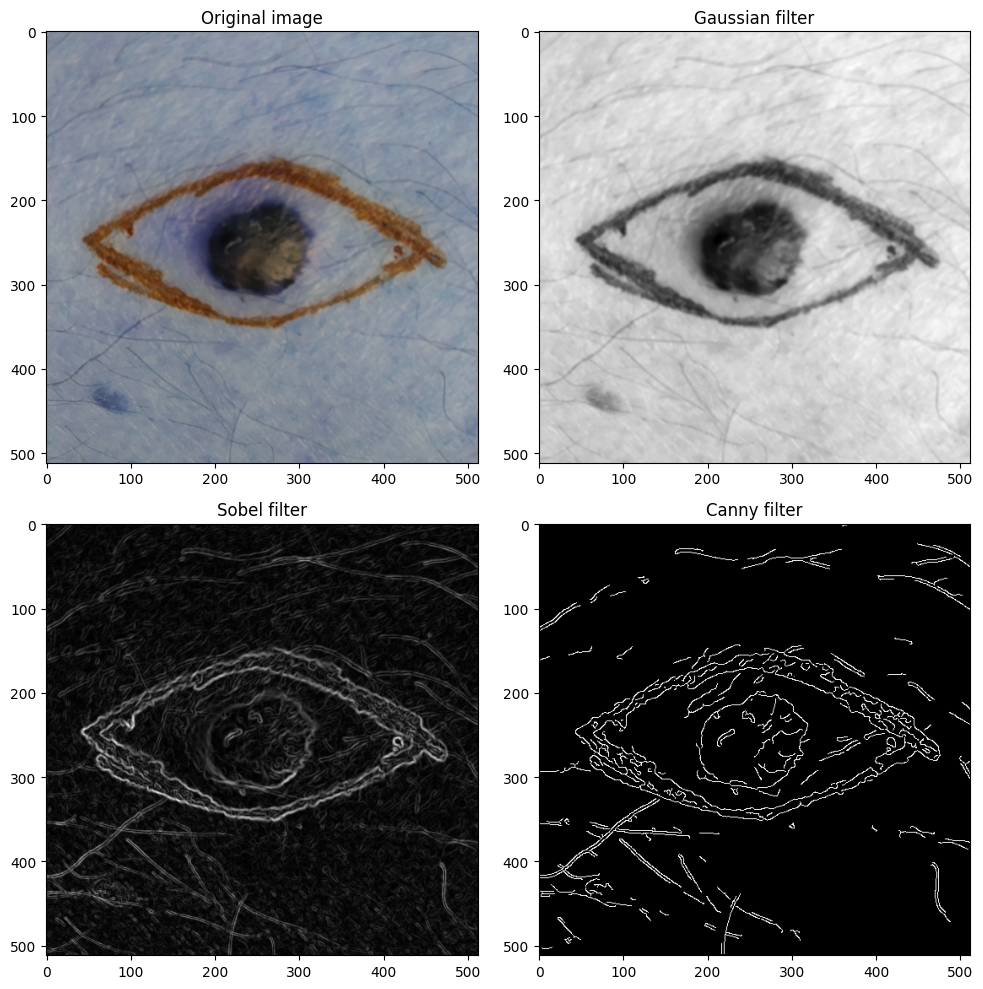

In [47]:
import cv2
from skimage import filters, feature
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply different filters to the image
gaussian_img = filters.gaussian(img_gray, sigma=1)
sobel_img = filters.sobel(img_gray)
prewitt_img = filters.prewitt(img_gray)
canny_img = feature.canny(img_gray, sigma=1)

# Display the original image and the filtered images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img)
axs[0, 0].set_title('Original image')
axs[0, 1].imshow(gaussian_img, cmap='gray')
axs[0, 1].set_title('Gaussian filter')
axs[1, 0].imshow(sobel_img, cmap='gray')
axs[1, 0].set_title('Sobel filter')
axs[1, 1].imshow(canny_img, cmap='gray')
axs[1, 1].set_title('Canny filter')

plt.tight_layout()
plt.show()


In [56]:
import cv2
import numpy as np
from skimage import feature, filters, morphology

# Load the image and convert to grayscale
img_path = '..\\..\\data\shanon_training\PAT_894_1679_640.PNG'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply various filters to the image
blur1 = filters.gaussian(gray, sigma=1)
blur2 = filters.gaussian(gray, sigma=3)
sobel_x = filters.sobel_v(gray)
sobel_y = filters.sobel_h(gray)
sobel_mag = filters.sobel(gray)
laplacian = filters.laplace(gray)
canny = feature.canny(gray, sigma=2)
erosion = morphology.erosion(gray, footprint=morphology.square(5))
dilation = morphology.dilation(gray, footprint=morphology.square(5))
opening = morphology.opening(gray, footprint=morphology.disk(5))
closing = morphology.closing(gray, footprint=morphology.disk(5))
median = filters.median(gray, footprint=morphology.disk(5))

# Collect features in a dataset
features = np.column_stack((
    blur1.ravel(),
    blur2.ravel(),
    sobel_x.ravel(),
    sobel_y.ravel(),
    sobel_mag.ravel(),
    laplacian.ravel(),
    canny.ravel(),
    erosion.ravel(),
    dilation.ravel(),
    opening.ravel(),
    closing.ravel(),
    median.ravel()
))

# Print dataset shape
print(features.shape)


(262144, 12)


dataset has 262,144 samples (pixels) and 12 dimensions (features)

Train a k-NN classifier on this dataset, and apply the classifier on a different
image. Remember, you need to also filter/transform this image.

Play around with this method, you can use for example https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py
for inspiration.

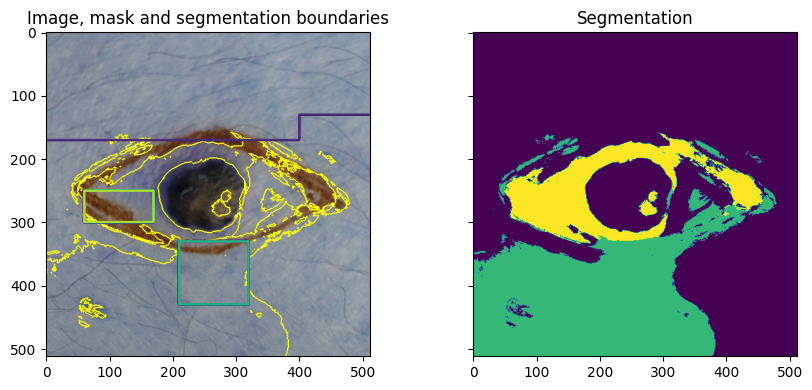

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

img = img[:900, :900]

training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels[:130] = 1
training_labels[:170, :400] = 1
training_labels[600:900, 200:650] = 2
training_labels[330:430, 210:320] = 3
training_labels[250:300, 60:170] = 4
training_labels[150:200, 720:860] = 4

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()